# Machine Problem: LaText

Group: For Loop
Memebers: Joshua Amador, Louise Denise Bacani, Zairra Mille Dela Calzada, Isaiah Nikolo Gonzales


Importing needed packages

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tfds.disable_progress_bar()

import csv
import string
import pathlib
import gzip
from tqdm import tqdm
import seaborn as sns
from itertools import groupby
from mlxtend.data import loadlocal_mnist
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
data_folder = Path("data/")
from sklearn.utils import shuffle

## Import datasets wikisplit and emnist-byclass

In [ ]:
!git clone https://github.com/google-research-datasets/wiki-split

Cloning into 'wiki-split'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (32/32), done.


In [ ]:
#load byclass dataset
train_ds, validation_ds = tfds.load(
    "emnist/byclass",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incomplete2G9ZGP/emnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incomplete2G9ZGP/emnist-test.tfrecord
Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.


Load sentences to local list

In [ ]:
raw_sentences = []  # empty list to store sentences
with open("wiki-split/test.tsv", "r", encoding="utf8") as f:
    reader = csv.reader(f, delimiter='\t')  # read a tsv file
    for row in tqdm(reader):
        raw_sentences.extend(row[1].split("<::::>"))
print("Total Sentences: ", len(raw_sentences))

5000it [00:00, 98613.86it/s]

Total Sentences:  10000


Remove punctuations as EMNIST does not contain punctuations

In [ ]:
import re

sentences = []
table = str.maketrans({key: None for key in string.punctuation})  # translation table

for sentence in raw_sentences:
    # remove punctuation and non-ascii characters
    clean_sentence = re.sub('  +', ' ', sentence.translate(table)).\
                        encode("ascii", 'ignore').decode()  
    sentences.append(clean_sentence.strip())  # add to clean sentences
    
print(sentences[99], '\n', raw_sentences[99])  # to verify

He was was arrested and booked on charges of first degree murder and first degree robbery 
  He was was arrested and booked on charges of first - degree murder and first - degree robbery .


In [ ]:
MAPPING = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z','a', 'b','c', 'd', 'e', 'f', 'g', 'h','i','j','k','l','m', 'n','o','p' ,'q', 'r','s', 't','u','v','w','x','y','z']
print(len(MAPPING))

62


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256

## We are transposing to rotate the image by 90 deg clockwise making the images human friendly.
def transpose(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # scale image pixels to [0,1]
  image = tf.transpose(image, [1,0,2]) # transpose to get human friendly image, since rotation
  return image, label

trainloader = (
    train_ds
    .shuffle(1024)
    .map(transpose, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

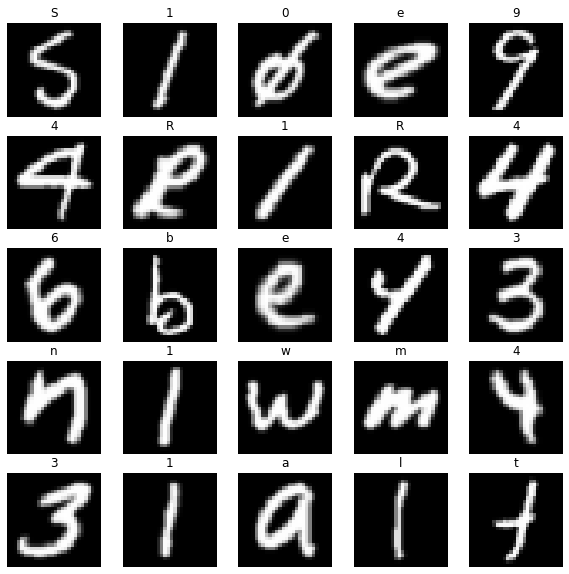

In [ ]:
plt.figure(figsize=(10, 10))
n = 0
for img, label in trainloader.take(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(tf.reshape(img, (28,28)), cmap='gray')
    plt.title(MAPPING[int(label.numpy())])
    plt.axis('off')
    n+=1

In [ ]:
IMAGES = []
LABELS = []

for img, label in tqdm(trainloader):
    IMAGES.append(tf.reshape(img, (28,28)).numpy())
    LABELS.append(label.numpy())

IMAGES = np.array(IMAGES)
LABELS = np.array(LABELS)

100%|██████████| 593242/593242 [07:21<00:00, 1342.33it/s]


In [ ]:
image_index = {}  # where key is the char and value is a list of IDs
for idx, label in tqdm(enumerate(LABELS)):
    
    char = MAPPING[label]
    if char in image_index:
        # this character already exists
        image_index[char].append(idx) # append index
    else:
        image_index[char] = [idx]  # initiate list with 1 item

593242it [00:00, 1225284.19it/s]


In [ ]:
def get_sample_sentences(sentences_in=sentences, num_sentence=10):
    # Get a defined number of sentences from the data
    return np.random.choice(sentences_in, num_sentence)

def get_generated_image(words, chars=IMAGES, index=image_index):
    # words is string of char/numbers that needs to be converted into an image
    # chars is a data set of images that need to be used to compose, usually pass in train['features'] in here
    # index maps a character to indexes in the images, available as dictionary
    height, width = IMAGES[0].shape # height and width of each character
    length = len(words) # total number of characters in the image
    
    # create an empty array to store the data
    image = np.zeros((height, width * length))
    pos = 0  # starting index of the character
    
    for char in words:
        if char is ' ':
            pos += width # if space, move over
        else:
            if char in image_index:
                # pick a random item from all images for that char
                idx = np.random.choice(image_index[char])  
                image[:, pos:(pos+width)] += chars[idx]
            elif char.upper() in image_index:  # to remove characters from other languages
                # for some characters, there is only upper case
                idx = np.random.choice(image_index[char.upper()])  
                image[:, pos:(pos+width)] += chars[idx]
            
            pos += width
    
    return image

NameError: ignored

['He forged an agreement with the Caribs so that they would not attack his ship']


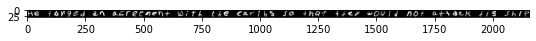

In [ ]:
# Let's print a sample to see how it looks
s = get_sample_sentences(sentences, 1)
print(s)
img = get_generated_image(s[0])
plt.figure(figsize=(9,2))
plt.imshow(img, cmap='gray')
plt.show()

Building a Sentence Training Set

In [ ]:
train_sentences = sentences[:2000]
test_sentences = sentences[2000:2500]


def generate_sentences(texts, chars, 
                           index, num_variants=2, max_length=32):

    
    # total number of samples to generate
    num_samples = len(texts) * num_variants
    height, width = chars[0].shape  # shape of image
    
    # setup empty array of the images
    images = np.zeros((num_samples, height, width * max_length), np.float64)
    labels = []
    
    for i, item in tqdm(enumerate(texts)):
        padded_item = item[0:max_length] if (len(item) > max_length) else item.ljust(max_length, ' ')
        
        for v in range(num_variants):
            img = get_generated_image(padded_item, chars, index)
            images[i*num_variants+v, :, :] += img
            labels.append(padded_item)
    
    return images, labels

In [ ]:
train_images, train_labels = generate_sentences(train_sentences, IMAGES, image_index)
test_images, test_labels = generate_sentences(test_sentences, IMAGES, image_index)

train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

NameError: ignored

In [ ]:
idx=0
print(train_labels[idx])
plt.figure(figsize=(9,2))
plt.imshow(train_images[idx], cmap='gray');
plt.show()

In [ ]:
# Now to save these models for easy loading
pp = pathlib.Path('.') / 'sentences'
pp.mkdir(exist_ok=True)  # create the directory

np.save(pp / 'train_images', train_images)
np.save(pp / 'test_images', test_images)
np.save(pp / 'train_labels', train_labels)
np.save(pp / 'test_labels', test_labels)

In [ ]:
# create a dictionary of mapping from 
mappings = dict(zip(np.arange(0, 62), MAPPING))
# add a space for spacing words
mappings[63] = ' '
# inverse: character as key and value as it's integer encoding
inverse_mappings = {v: k for k, v in mappings.items()}

In [ ]:
# now convert categorical labels from the sentences
encode = lambda x: [inverse_mappings[xi] if xi in inverse_mappings else inverse_mappings[xi.upper()] for xi in x]
decode = lambda x: [mappings[xi] for xi in x]

train_labels_cat = np.array([encode(xi) for xi in train_labels])
test_labels_cat = np.array([encode(xi) for xi in test_labels])

# Verify the encoding/decoding
print(train_labels[1])
print(train_labels_cat.shape, train_labels_cat[1])
print(decode(train_labels_cat[1]))

Bratislava Regio was abolished i
(4000, 32) [11 53 36 55 44 54 47 36 57 36 63 27 40 42 44 50 63 58 36 54 63 36 37 50
 47 44 54 43 40 39 63 44]
['B', 'r', 'a', 't', 'i', 's', 'l', 'a', 'v', 'a', ' ', 'R', 'e', 'g', 'i', 'o', ' ', 'w', 'a', 's', ' ', 'a', 'b', 'o', 'l', 'i', 's', 'h', 'e', 'd', ' ', 'i']


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

# This step will make sense after looking at the model
def merge_image_label(image, label):
    return (image, label), label

trainloader = tf.data.Dataset.from_tensor_slices((train_images, train_labels_cat))
testloader = tf.data.Dataset.from_tensor_slices((test_images, test_labels_cat))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(merge_image_label, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(merge_image_label, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:

IMG_H, IMG_W = train_images[1].shape

OUTPUT_LENGTH = 32  

NUM_CLASSES = 64 

In [ ]:
PATCH_WIDTH = 20
PATCH_STRIDE = 14
def extract_patches(image):
    kernel = [1, 1, PATCH_WIDTH, 1]
    strides = [1, 1, PATCH_STRIDE, 1]
    patches = tf.image.extract_patches(image, kernel, strides, [1, 1, 1, 1], 'VALID')
    patches = tf.transpose(patches, (0, 2, 1, 3))
    patches = tf.expand_dims(patches, -1)
    return patches

In [ ]:
def ImagePatchEncoder():
  patched_inputs = Input(shape=(IMG_H, PATCH_WIDTH, 1))
  x = Conv2D(32, kernel_size=(3, 3), activation='relu')(patched_inputs)
  x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.2)(x)
  flattened_outputs = Flatten()(x)

  return Model(inputs=patched_inputs, outputs=flattened_outputs, name='base')

tf.keras.backend.clear_session()
image_patch_encoder = ImagePatchEncoder()
image_patch_encoder.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 20, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 18, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 16, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 8, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 8, 64)         0         
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                              

In [ ]:
class CTCLayer(Layer):
  def __init__(self, name=None):

      super().__init__(name=name)
      self.loss_fn = tf.keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
      # Compute the training-time loss value and add it
      # to the layer using `self.add_loss()`.

      batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
      input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
      label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

      input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
      label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

      loss = self.loss_fn(y_true, y_pred, input_length, label_length)
      self.add_loss(loss)

      # At test time, just return the computed predictions
      return y_pred

In [ ]:
def ImagetoSequence():
  # IMAGE ENCODER #
  labels = Input(name="label", shape=(None,), dtype="float32")
  image_input = Input(shape=(IMG_H, IMG_W), name="cnn_input")
  # reshape to add dimensions
  image_reshaped = Reshape((IMG_H, IMG_W, 1))(image_input)
  # extract patches of images
  image_patches = Lambda(extract_patches)(image_reshaped)
  # get CNN backbone architecture to get embedding for each patch
  image_patch_encoder = ImagePatchEncoder()
  # Wrapper allows to apply a layer to every temporal slice of an input.
  time_wrapper = TimeDistributed(image_patch_encoder)(image_patches)

  # RECURRENT NETWORK #
  lstm_out = LSTM(128, return_sequences=True, name="lstm")(time_wrapper)
  softmax_output = Dense(NUM_CLASSES, activation='softmax', name="lstm_softmax")(lstm_out)
  # 
  output = CTCLayer(name="ctc_loss")(labels, softmax_output)

  return Model([image_input, labels], output)

In [ ]:
tf.keras.backend.clear_session()
model = ImagetoSequence()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cnn_input (InputLayer)         [(None, 28, 896)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 28, 896, 1)   0           ['cnn_input[0][0]']              
                                                                                                  
 lambda (Lambda)                (None, 63, 28, 20,   0           ['reshape[0][0]']                
                                1)                                                                
                                                                                                  
 time_distributed (TimeDistribu  (None, 63, 6144)    18816       ['lambda[0][0]']             

In [108]:
model.compile(tf.keras.optimizers.Adam())

In [109]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', restore_best_weights=True)

In [ ]:
_ = model.fit(trainloader,  
                    validation_data=testloader,
                    epochs=10,
                    callbacks=[
                               early_stopper])

Epoch 1/10
63/63 [==============================] - 525s 8s/step - loss: 14.4811 - val_loss: 14.8622
Epoch 2/10
63/63 [==============================] - 516s 8s/step - loss: 12.2310 - val_loss: 13.3025
Epoch 3/10
63/63 [==============================] - 518s 8s/step - loss: 10.7713 - val_loss: 12.1205
Epoch 4/10
63/63 [==============================] - 519s 8s/step - loss: 9.6820 - val_loss: 11.2282
Epoch 5/10
63/63 [==============================] - 510s 8s/step - loss: 8.7724 - val_loss: 10.4267
Epoch 6/10
63/63 [==============================] - 511s 8s/step - loss: 8.0195 - val_loss: 9.8614
Epoch 7/10
63/63 [==============================] - 510s 8s/step - loss: 7.4056 - val_loss: 9.3552
Epoch 8/10
63/63 [==============================] - 509s 8s/step - loss: 6.8472 - val_loss: 9.0678
Epoch 9/10
14/63 [=====>........................] - ETA: 6:14 - loss: 6.4544

In [ ]:
model.evaluate(X, Y)